# Overview
- nb011の改良
- この[ディスカッション](https://www.guruguru.science/competitions/13/discussions/df06ef19-981d-4666-a0c0-22f62ee26640/)を見たところ、["Publisher", "Developer", "Name"] は学習から除いた方がいいそうなので除く。

# Const

In [1]:
NB = '012'
N_SPLITS = 5
SHOW_LOG = True
VERBOSE = 10
# VERBOSE = None
EARLY_STOPPING_ROUNDS = 100


PATH_TRAIN = './../data/official/train.csv'
PATH_TEST = './../data/official/test.csv'
PATH_SAMPLE_SUBMITTION = './../data/official/atmaCup8_sample-submission.csv'
SAVE_DIR = f'../data/output_nb/nb{NB}/'

feat_train_only = ['JP_Sales', 'Global_Sales', 'NA_Sales', 'Other_Sales', 'EU_Sales']
feat_common = ['Name', 'Platform', 'Year_of_Release', 'Genre', 'Publisher',
           'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count', 'Developer',
           'Rating']
feat_string = ['Platform', 'Genre', 'Publisher', 'Developer', 'Rating']
feat_cat = ['Platform', 'Genre', 'Rating']
feat_num = ['Year_of_Release', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count']
use_col = [
    'Platform',
    'Year_of_Release',
    'Genre',
    'Critic_Score',
    'Critic_Count',
    'User_Score',
    'User_Count',
    'Rating'
    ]

# Import everything I need :)

In [2]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor 

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split, KFold

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


# My function

In [3]:
def metric(y_true, y_pred):
    return mean_squared_log_error(y_true, y_pred) ** .5

def preprocess_User_Score(df):
    '''
    - tbdをnanにする
    - stringをfloatにする
    '''
    mask = df.User_Score.values == 'tbd'
    df.User_Score[mask] = np.nan
    df.User_Score = df.User_Score.values.astype(float)
    return df

def string_encode(df_trn, df_te, cols):
    '''
    - np.nanがあれば、'nan'に置き換える
    - label encodingする
    '''
    df = pd.concat([df_trn, df_te], axis=0).copy()
    df[cols] = df[cols].replace(np.nan, 'nan')
    df_trn[cols] = df_trn[cols].replace(np.nan, 'nan')
    df_te[cols] = df_te[cols].replace(np.nan, 'nan')
    for col in cols:
        le = LabelEncoder()
        le.fit(df[col])
        df_trn[col] = le.transform(df_trn[col])
        df_te[col] = le.transform(df_te[col])
    return df_trn, df_te

def df_preprocessing(df_trn, df_te, string_cols):
    df_trn = preprocess_User_Score(df_trn)
    df_te = preprocess_User_Score(df_te)
    df_trn, df_te = string_encode(df_trn, df_te, string_cols)
    return df_trn, df_te

In [4]:
def run_fold_lgbm(_X_trn, _y_trn, _X_val, _y_val, _X_te, model_config, feat_cat, show_log=True):
    
    # train
    model = LGBMRegressor(objective='regression', metric='rmse', **model_config)
    model.fit(_X_trn, _y_trn.values[:, 0],
              categorical_feature=feat_cat,
              eval_set=[(_X_trn, _y_trn), (_X_val, _y_val)],
              verbose=VERBOSE,
              early_stopping_rounds=EARLY_STOPPING_ROUNDS,
             )
    
    # predict
    y_trn_pred = model.predict(_X_trn)
    y_val_pred = model.predict(_X_val)
    _y_test_pred = model.predict(_X_te)
    
    # postprocessiing
    y_trn_pred[y_trn_pred <= 1] = 1
    y_val_pred[y_val_pred <= 1] = 1
    y_trn_pred = np.expm1(y_trn_pred)  # exp を適用して 1 を引く
    y_val_pred = np.expm1(y_val_pred)  # exp を適用して 1 を引く
    _y_test_pred = np.expm1(_y_test_pred)  # exp を適用して 1 を引く
    
    if show_log:
        print(show_log)
        print(f'score train: {metric(np.expm1(_y_trn), y_trn_pred):.5f}')
        print(f'score valid: {metric(np.expm1(_y_val), y_val_pred):.5f}')
        print('')
    
    return y_trn_pred, y_val_pred, _y_test_pred

def run(X, y, X_te, splitter, use_col, model_config, feat_cat, show_log=True):
    print(f'use_col: {use_col}\n') if show_log else None

    oof = np.zeros(len(X))
    y_test_pred = np.zeros(len(X_te))
    for fold_i, (idx_trn, idx_val) in enumerate(splitter.split(X)):
        if show_log:
            print(f'::Fold {fold_i+1}/{N_SPLITS} start at {time.ctime()}::')
        X_trn, X_val = X.iloc[idx_trn, :], X.iloc[idx_val, :]
        y_trn, y_val = y.iloc[idx_trn], y.iloc[idx_val]
        X_trn = pd.DataFrame(X_trn, columns=X.columns)
        X_val = pd.DataFrame(X_val, columns=X.columns)

        # train
        y_trn_pred, y_val_pred, _y_test_pred = run_fold_lgbm(X_trn, y_trn, X_val, y_val, 
                                                             X_te, model_config, 
                                                             feat_cat, show_log=show_log)

        # result
        oof[idx_val] = y_val_pred
        y_test_pred += _y_test_pred / N_SPLITS


    y_test_pred[y_test_pred <= 1] = 1
    return oof, y_test_pred

# Preparation

set

In [5]:
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

<br>

load dataset

In [6]:
train = pd.read_csv(PATH_TRAIN)
test = pd.read_csv(PATH_TEST)
ss = pd.read_csv(PATH_SAMPLE_SUBMITTION)

<br>

preprocess

In [7]:
train, test = df_preprocessing(train, test, feat_string)

In [8]:
X = train[use_col].copy()
y = train[['Global_Sales']].copy()
X_te = test[use_col].copy()

In [9]:
X

,Platform,Year_of_Release,Genre,Critic_Score,Critic_Count,User_Score,User_Count,Rating
0,26,NaN,0,74.0,17.0,7.9,22.0,2
1,26,NaN,0,78.0,22.0,6.6,28.0,2
2,19,NaN,0,73.0,5.0,7.4,10.0,2
3,0,NaN,0,NaN,NaN,NaN,NaN,8
4,26,NaN,0,76.0,8.0,7.8,13.0,2
...,...,...,...,...,...,...,...,...
8354,13,2016.0,11,78.0,57.0,8.0,569.0,8
8355,13,2016.0,11,NaN,NaN,NaN,NaN,8
8356,20,2017.0,0,NaN,NaN,NaN,NaN,8
8357,18,2017.0,7,NaN,NaN,NaN,NaN,8


In [10]:
# RMSLE を RMSEとしいて解く
y = np.log1p(y)  # 1 を足してlog を適用

# Create Model

In [11]:
splitter = KFold(n_splits=N_SPLITS, shuffle=True, random_state=2020)

In [12]:
model_config = {
    'n_estimators': 800,
    'max_depth': 55,
    'subsample': 0.5,
    'colsample_bytree': 0.9, 
#     'learning_rate': 0.006437110612661787,
    'learning_rate': 0.02,
    'reg_alpha': 5.0,
    'reg_lambda': 5.0,
    'min_child_samples': 57
    }

In [15]:
%%time
oof, y_test_pred = run(X, y, X_te, splitter, use_col, model_config, feat_cat, show_log=SHOW_LOG)
print(f'oof score: {metric(np.expm1(y), oof):.5f}')

use_col: ['Platform', 'Year_of_Release', 'Genre', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count', 'Rating']

::Fold 1/5 start at Mon Dec  7 08:04:21 2020::
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 1.30463	valid_1's rmse: 1.29174
[20]	valid_0's rmse: 1.23766	valid_1's rmse: 1.22938
[30]	valid_0's rmse: 1.18245	valid_1's rmse: 1.17851
[40]	valid_0's rmse: 1.14143	valid_1's rmse: 1.14196
[50]	valid_0's rmse: 1.10831	valid_1's rmse: 1.11281
[60]	valid_0's rmse: 1.08323	valid_1's rmse: 1.09182
[70]	valid_0's rmse: 1.06302	valid_1's rmse: 1.07557
[80]	valid_0's rmse: 1.04721	valid_1's rmse: 1.06304
[90]	valid_0's rmse: 1.03424	valid_1's rmse: 1.05351
[100]	valid_0's rmse: 1.02336	valid_1's rmse: 1.04575
[110]	valid_0's rmse: 1.01451	valid_1's rmse: 1.03967
[120]	valid_0's rmse: 1.00654	valid_1's rmse: 1.03421
[130]	valid_0's rmse: 0.999888	valid_1's rmse: 1.03015
[140]	valid_0's rmse: 0.993705	valid_1's rmse: 1.0261
[150]	valid_0's rmse: 

# create sub

In [16]:
ss['Global_Sales'] = y_test_pred
save_path = f'{SAVE_DIR}submission.csv'
ss.to_csv(save_path, index=False)

print(f'save: {save_path}')

save: ../data/output_nb/nb012/submission.csv


# Analysis

Text(0, 0.5, 'Pred')

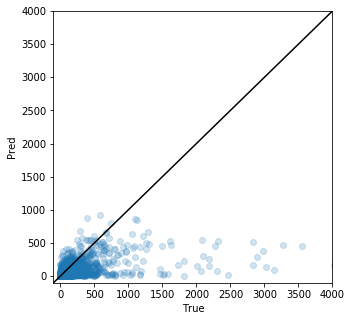

In [17]:
plt.figure(figsize=(5, 5))
plt.plot([-200, 8000], [-200, 8000], color='black')
plt.scatter(np.expm1(y), oof, alpha=0.2)
plt.xlim(-100, 4000)
plt.ylim(-100, 4000)
plt.xlabel('True')
plt.ylabel('Pred')

(-100, 1000)

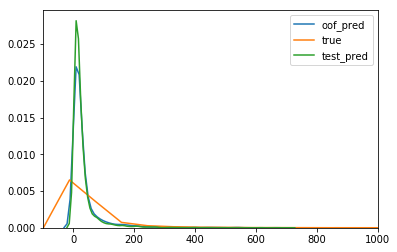

In [18]:
sns.kdeplot(oof, label='oof_pred')
sns.kdeplot(np.expm1(y.Global_Sales.values), label='true')
sns.kdeplot(y_test_pred, label='test_pred')
plt.xlim(-100, 1000)